In [ ]:
# This notebook contains the hull finding and improving methods.
# Saves the hull to a text file at the end.
# This notebook should run cleanly all the way through with graphics to ensure it's been done right.

In [3]:
%matplotlib inline
import astropy.table
import matplotlib.pyplot as plot
import matplotlib.image as image
import matplotlib.path as path
import numpy as np

import os

import math

from matplotlib.patches import Rectangle, Polygon

from scipy.spatial import Delaunay

tiles = astropy.table.Table.read('desi-tiles.fits', hdu=1)
sel = (tiles['IN_DESI'] > 0) & (tiles['PASS'] < 8)
ra = tiles['RA'][sel]
dec = tiles['DEC'][sel]

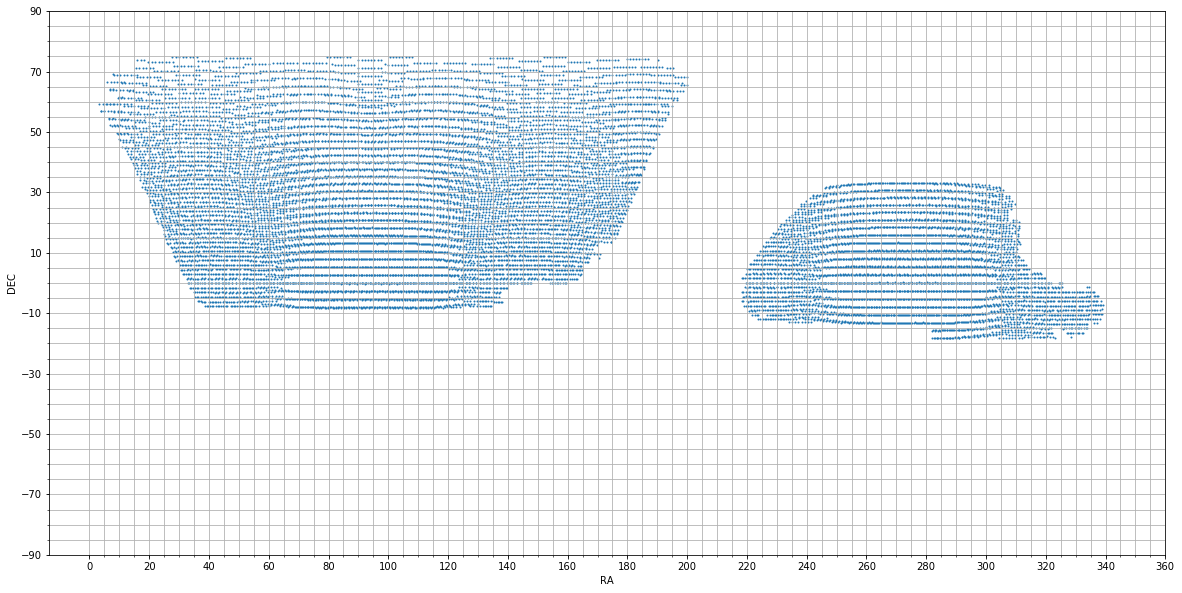

In [205]:
fig,ax = plot.subplots()

tiles = astropy.table.Table.read('desi-tiles.fits', hdu=1)
sel = (tiles['IN_DESI'] > 0) & (tiles['PASS'] < 8)
ra = tiles['RA'][sel]
dec = tiles['DEC'][sel]

for i in range(0,len(ra)):
    if ra[i] > 90:
        ra[i] = ra[i] - 90
    else:
        ra[i] = ra[i] - 90 + 360

ax.scatter(ra, dec, s = 1)

ax.set_yticks(range(-90,95,5), minor = True)
ax.set_yticks(range(-90,100,20), minor = False)
ax.set_xticks(range(0,365,5), minor = True)
ax.set_xticks(range(0,365,20), minor = False)
ax.grid(which = 'minor')

#ax.add_patch(Rectangle((120,0),5,5,fill=False, edgecolor='red',lw=2))
plot.xlabel("RA")
plot.ylabel("DEC")

fig.set_size_inches(20,10)

plot.show()

In [142]:
corners = []
increment = 2
for x in range(0, 365, increment):
    for y in range(-30, 80, increment):
        for i in range(0, len(ra)):
            if x <= ra[i] <= x + increment and y <= dec[i] <= y + increment:
                corners.append((x, y))

In [143]:
corners2 = []
for i in range(0,len(corners)):
    x,y = corners[i]
    right = False
    left = False
    top = False
    bottom = False
    
    if (x+increment, y) in corners:
        right = True
    if (x-increment, y) in corners:
        left = True
    if (x, y+increment) in corners:
        top = True
    if (x, y-increment) in corners:
        bottom = True
        
    if not(top and right and left and bottom):
        corners2.append((x, y))

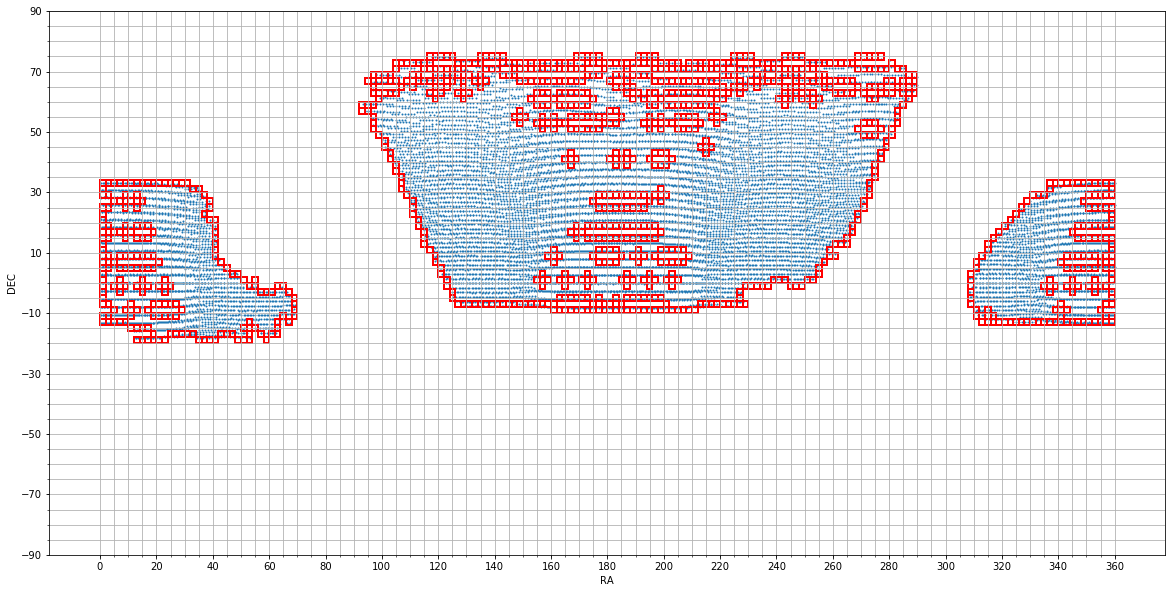

In [144]:
fig,ax = plot.subplots()


ax.scatter(ra, dec, s = 1)

ax.set_yticks(range(-90,95,5), minor = True)
ax.set_yticks(range(-90,100,20), minor = False)
ax.set_xticks(range(0,365,5), minor = True)
ax.set_xticks(range(0,365,20), minor = False)
ax.grid(which = 'minor')

for corner in corners2:
    ax.add_patch(Rectangle(corner,increment,increment,fill=False, edgecolor='red',lw=2))


plot.xlabel("RA")
plot.ylabel("DEC")

fig.set_size_inches(20,10)

plot.show()

In [10]:
# Newton's method for eckert-iv proection.
def eckertiv_findtheta(phi, n):
    # First short circuit
    if n == 0:
        return phi/2

    pi = math.pi

    # Array literally just filled with half pis.
    halfpi = np.empty(len(phi))
    halfpi.fill(pi/2)

    theta = eckertiv_findtheta(phi, n-1)

    # Condition for the angle is pi/2 OR -pi/2
    cond1 = np.equal(theta, halfpi)
    cond2 = np.equal(theta, -1*halfpi)
    cond = np.logical_or(cond1, cond2)

    # Choose the original value (pi/2 or -pi/2) if its true for equality
    # Otherwise use that value's thetanew.
    # This is the eckertiv theta finding Newton's method.
    # It's been broken up for style.
    s_theta = np.sin(theta)
    c_theta = np.cos(theta)
    num = theta + np.multiply(s_theta, c_theta) + 2 * s_theta - (2 + pi/2) * np.sin(phi)
    denom = 2 * c_theta * (1 + c_theta)
    thetanew = theta - num/denom
    thetanew = np.where(cond, phi, thetanew)

    return thetanew


def eckertiv(ra, dec):
    # Center latitude
    center = math.radians(180)

    # n = 5 seems to be sufficient for the shape.
    # This doesn't converge as quickly as Mollweide
    theta = eckertiv_findtheta(np.radians(dec), 5)

    R = 100

    # For readability sake
    coeff = 1/math.sqrt(math.pi*(4+math.pi))

    # Eckert IV conversion functions.
    x = 2 * R * coeff * np.subtract(np.radians(ra), center) * (1 + np.cos(theta))
    y = 2 * R * math.pi * coeff * np.sin(theta)

    return(x, y)

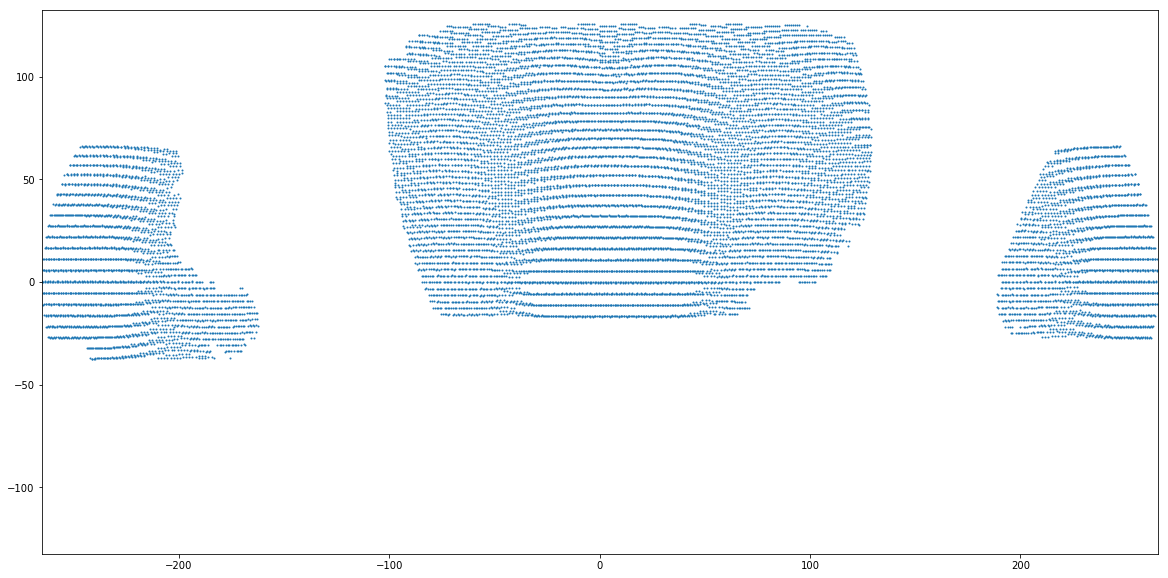

In [10]:
fig,ax = plot.subplots()

x,y = eckertiv(ra,dec)

ax.set_xlim(-265.3,265.3)
ax.set_ylim(-132.582101423,132.582101423)

ax.scatter(x, y, s=1)

fig.set_size_inches(20,10)

plot.show()

In [3]:
mid = []
right = []
left = []

tiles = astropy.table.Table.read('desi-tiles.fits', hdu=1)
sel = (tiles['IN_DESI'] > 0) & (tiles['PASS'] < 8)
ra = tiles['RA'][sel]
dec = tiles['DEC'][sel]

for i in range(0,len(ra)):
    if 90 < ra[i] < 300:
        mid.append((ra[i], dec[i]))
    elif 300 < ra[i]:
        right.append((ra[i], dec[i]))
    else:
        left.append((ra[i], dec[i]))

In [9]:
def jarvis(points):
    #print(points.type)
    points = list(set(points))
    sort = sorted(points)
    
    # Starting at the rightmost point rather than the left most has been more accurate.
    start = sort[-1]
    
    # The start has no "previous point" so just use a point slightly above the start.
    curr = nextpoint(start, (start[0], start[1] + 1), points)
    
    # The hull is kept in the result array.
    result = []
    result.append(start)
    result.append(curr)
    
    prev = start
    nextp = (0,0)
    
    # Loop that continues stepping along the hull until we're back at the start
    i = 0
    while not nextp == start:
        nextp = nextpoint(curr, prev, points)
        result.append(nextp)
        prev = curr
        curr = nextp
        i += 1
    
    return result


def nextpoint(curr, prev, points):
    
    thetalist = []
    potentials = []
    
    # Putting these outside the loop means we don't have to run it every time.
    v_p = (prev[0] - curr[0], prev[1] - curr[1])
    v_p = v_p / np.linalg.norm(v_p)
    
    for point in points:
        v_c = (point[0] - curr[0], point[1] - curr[1])
        v_c2 = v_c / np.linalg.norm(v_c)
        
        # Always finds the inner angle between the check point and the previous hull point.
        theta = np.arccos(np.clip(np.dot(v_c2, v_p), -1.0, 1.0))
        
        
        cross = np.cross(v_p, v_c)
        #if cross < 0:
            #theta = 2*math.pi - theta
        
        thetalist.append(theta)
        
    
    sort = sorted(thetalist)
    index = thetalist.index(sort[-1])
    
    #print(sort[-1])
    return points[index]



/Users/dylan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


[(289.89999999999998, 65.420000000000002), (265.98000000000002, 14.91), (260.46000000000004, 8.4000000000000004), (253.08000000000004, 1.4199999999999999), (249.55999999999995, -0.050000000000000003), (224.44000000000005, -7.6100000000000003), (210.99000000000001, -8.0399999999999991), (208.15999999999997, -8.1300000000000008), (205.38999999999999, -8.1699999999999999), (202.63999999999999, -8.1899999999999995), (175.22000000000003, -8.1899999999999995), (172.48000000000002, -8.1899999999999995), (169.73000000000002, -8.1799999999999997), (130.84000000000003, -7.6900000000000004), (128.69, -7.6600000000000001), (126.67000000000002, -6.1200000000000001), (125.29000000000002, -4.5899999999999999), (122.81999999999999, -0.029999999999999999), (118.95999999999998, 7.2699999999999996), (93.909999999999968, 56.93), (93.360000000000014, 59.340000000000003), (95.95999999999998, 66.560000000000002), (98.0, 69.079999999999998), (105.99000000000001, 73.879999999999995), (117.76999999999998, 74.98

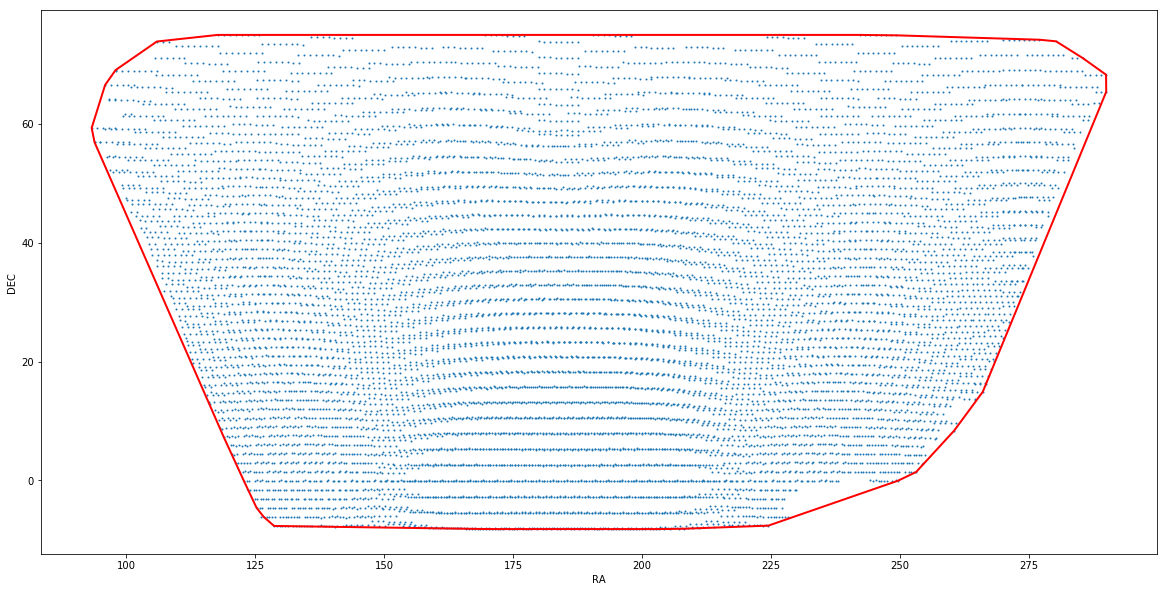

In [5]:
fig,ax = plot.subplots()

fig.set_size_inches(20,10)

ra = []
dec = []
for i in range(0,len(mid)):
    ra.append(mid[i][0])
    dec.append(mid[i][1])

ax.scatter(ra, dec, s = 1)

#ax.set_yticks(range(-90,95,5), minor = True)
#ax.set_yticks(range(-90,100,20), minor = False)
#ax.set_xticks(range(0,365,5), minor = True)
#ax.set_xticks(range(0,365,20), minor = False)
#ax.grid(which = 'minor')

#ax.add_patch(Rectangle((120,0),5,5,fill=False, edgecolor='red',lw=2))
plot.xlabel("RA")
plot.ylabel("DEC")

hull = jarvis(mid)
#print(hull)

patch = Polygon(hull, closed = True, fill = False, edgecolor='red',lw=2)
ax.add_patch(patch)

#ax.plot(hull[0], hull[1],'r')



plot.show()

In [232]:
blah = [(1,1),(2,2),(3,3)]
list(np.subtract(tuple((1,1)), blah))

TypeError: 'numpy.ndarray' object is not callable

In [233]:
v1 = [1,1]
v2 = [-1,1]

v1 = v1 / np.linalg.norm(v1)
v2 = v2 / np.linalg.norm(v2)

np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))

1.5707963267948966

In [234]:
x = [-1,-1]
y = [-1,1]

print(np.cross(y,x))

2


In [235]:
mid2 = []
for i in mid:
    mid2.append(np.asarray(i))
    
mid2 = np.asarray(mid2)

In [8]:

def hull_bisect(hull, points):

    newhull = []
    for i in range(0,len(hull)):
        curr = hull[i]
        if not i == len(hull) - 1:
            nextp = hull[i + 1]
        else:
            nextp = hull[0]
    
        midpoint = ((curr[0] + nextp[0]) / 2, (curr[1] + nextp[1]) / 2)
        # We only want to splice if the length of the side is longer than a certain length.
        v1 = (nextp[0] - curr[0], nextp[1] - curr[1])
        d1 = np.linalg.norm(v1)
        
        
        newhull.append(curr)
        
        if d1 > 5:
            #print(d1)
            l = 100
            best = (0,0)
    
            for point in points:
                v = (point[0] - midpoint[0], point[1] - midpoint[1])
            
            
            #d = np.linalg.norm(np.cross(nextp-curr, curr-point))/np.linalg.norm(nextp-curr)
            
                d = np.linalg.norm(v)
        
                if d < l:
                    l = d
                    best = point
            
        
            if not best == (0,0):
                newhull.append(best)
        
    return newhull


/Users/dylan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/Users/dylan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/dylan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


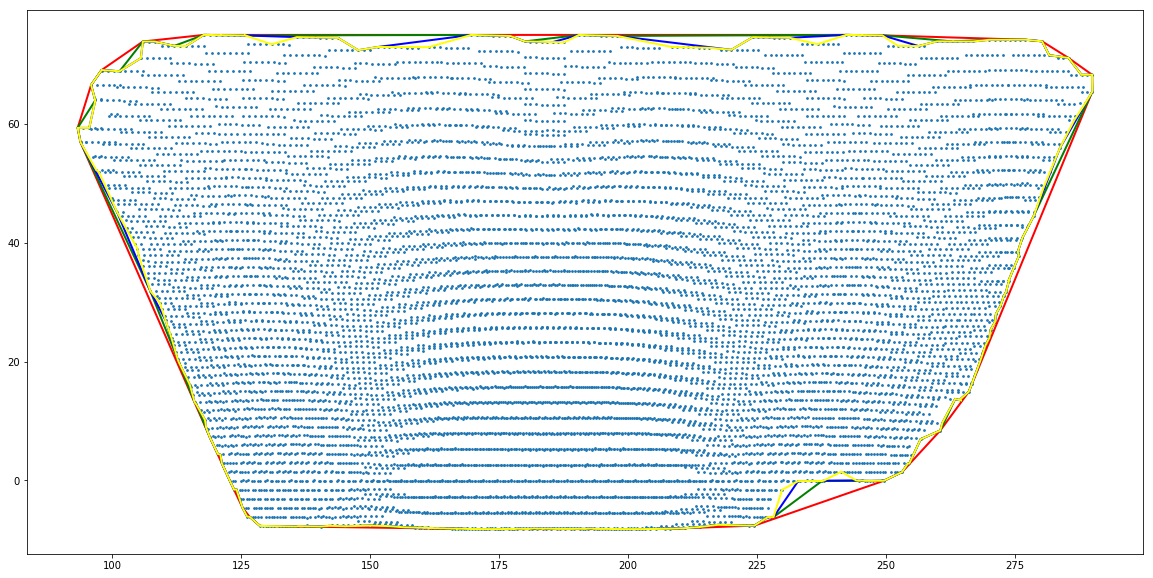

In [191]:
fig,ax = plot.subplots()

fig.set_size_inches(20,10)

ra = []
dec = []
for i in range(0,len(mid)):
    ra.append(mid[i][0])
    dec.append(mid[i][1])

#left = left.tolist()
hull = jarvis(mid)

# Don't want to change the old hull so put in a new copy of it
newhull = improve(list(hull), mid)
newhull2 = improve(list(newhull), mid)
newhull3 = improve(list(newhull2), mid)

#newhull2 = list(set(newhull2))

#print(newhull2)

ax.scatter(ra, dec, s = 3)


patch = Polygon(hull, closed = True, fill = False, edgecolor='red',lw=2)
patch2 = Polygon(newhull, closed = True, fill = False, edgecolor='green',lw=2)
patch3 = Polygon(newhull2, closed = True, fill = False, edgecolor='blue',lw=2)
patch4 = Polygon(newhull3, closed = True, fill = False, edgecolor='yellow',lw=2)
ax.add_patch(patch)
ax.add_patch(patch2)
ax.add_patch(patch3)
ax.add_patch(patch4)



plot.show()

In [5]:
def correct(hull, points):
    new = list(hull)
    hullshape = path.Path(hull)
    
    for point in points:
        if not hullshape.contains_point(point):
            new.append(point)
      
    
    # Remove any duplicates we picked up on the way
    new = list(set(new))
    new = clockwise_sort(new)
    return new
        
def clockwise_sort(tosort):
    tosort = np.array(tosort)
    x = tosort[:,0]
    y = tosort[:,1]
    
    x = x.tolist()
    y = y.tolist()
    
    x = sorted(x)
    y = sorted(y)
    
    centerx = (x[0] + x[-1])/2 + 5
    centery = (y[0] + y[-1])/2 - 5
    
    center = (centerx, centery)
    
    tosort = np.subtract(tosort, center)
    
    # Slices out the x and y portions
    x = tosort[:,0]
    y = tosort[:,1]
    
    # Creates polar nonsense
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    
    # Reshape to stack
    r = np.reshape(r, (r.shape[0], 1))
    theta = np.reshape(theta, (theta.shape[0], 1))
    
    # Stack into list of form (theta,r) (we want to sort theta first)
    stack = np.hstack((theta,r))
    
    stack2 = []
    for i in stack:
        stack2.append(tuple(i))
        
    # Standard python sort by theta
    stack2 = sorted(stack2)
    
    # Now we just have to convert back!
    # Slice out theta and r
    stack2 = np.array(stack2)
    theta = stack2[:,0]
    r = stack2[:,1]
    
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    result = []
    for i in range(0,len(x)):
        result.append((x[i] + center[0],y[i] + center[1]))
    
    return result
    

In [6]:
def improve(hull, points):
    temp = hull_bisect(hull, points)
    temp = correct(temp, points)
    temp = angles(temp)
    temp = angles(temp)
    return angles(temp)

In [7]:
def angles(hull):
    vertices = list(hull)
    
    thetalist = []
    remove = []
    for i in range(0,len(vertices)):
        curr = vertices[i]
        
        # Code for carryover at the end
        if not i == len(vertices) - 1:
            nextp = vertices[i + 1]
        else:
            nextp = vertices[0]
            
        if not i == 0:
            prev = vertices[i-1]
        else:
            prev = vertices[-1]
            
        # Finds the angle using dot product
        v_p = (prev[0] - curr[0], prev[1] - curr[1])
        v_p = v_p / np.linalg.norm(v_p)
        
        v_n = (nextp[0] - curr[0], nextp[1] - curr[1])
        v_n = v_n / np.linalg.norm(v_n)
        
        theta = np.arccos(np.clip(np.dot(v_n, v_p), -1.0, 1.0))
        
        # Make the angle the inner angle if we found the outer one
        if np.cross(v_n, v_p) <= 0:
            theta = 2*math.pi - theta
        if theta > 5.2:
            remove.append(curr)
        
        thetalist.append(theta)
    
    newhull = list(vertices)
    
    for point in remove:
        newhull.remove(point)
    
    newhull = clockwise_sort(newhull)
    return newhull

/Users/dylan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/Users/dylan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/dylan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


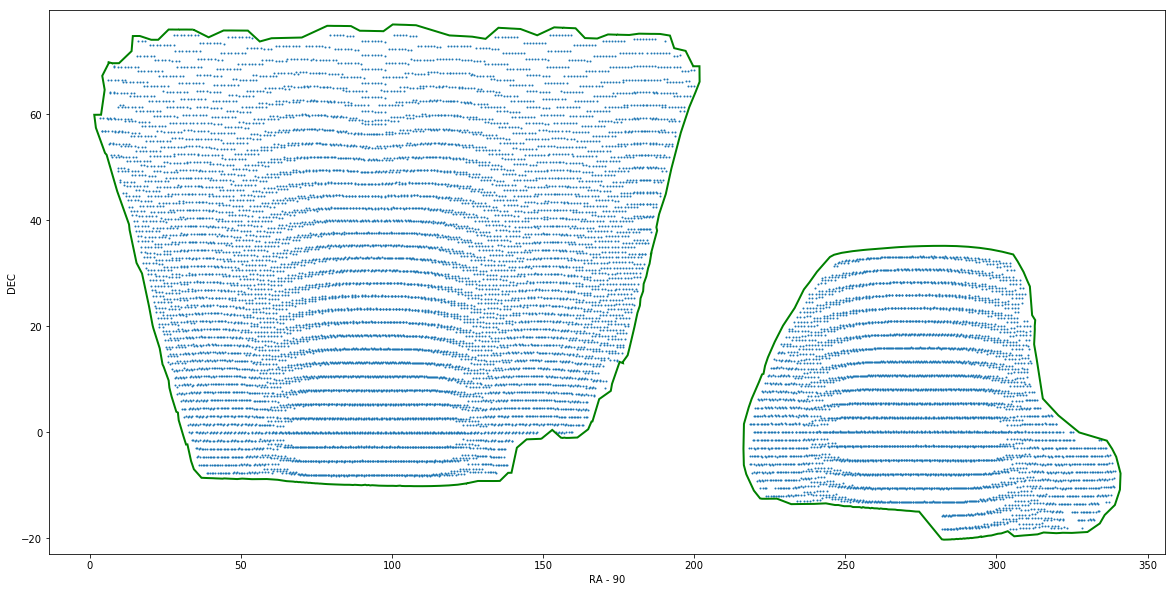

In [259]:
tiles = astropy.table.Table.read('desi-tiles.fits', hdu=1)
sel = (tiles['IN_DESI'] > 0) & (tiles['PASS'] < 8)
ra = tiles['RA'][sel]
dec = tiles['DEC'][sel]

for i in range(0,len(ra)):
    if ra[i] > 90:
        ra[i] = ra[i] - 90
    else:
        ra[i] = ra[i] - 90 + 360
        
fig,ax = plot.subplots()
ax.scatter(ra, dec, s = 1)

mid = []
right = []
left = []

for i in range(0,len(ra)):
    if ra[i] < 300 - 90:
        left.append((ra[i], dec[i]))
    else:
        right.append((ra[i], dec[i]))

        
hullleft = jarvis(left)
hullright = jarvis(right)

for i in range(0,3):
    hullleft = improve(hullleft, left)
    hullright = improve(hullright, right)
    
hullleft2 = expand_hull(hullleft)
hullright2 = expand_hull(hullright)

patch1 = Polygon(hullleft, closed = True, fill = False, edgecolor='red',lw=2)
patch2 = Polygon(hullright, closed = True, fill = False, edgecolor='red',lw=2)
patch3 = Polygon(hullleft2, closed = True, fill = False, edgecolor='green',lw=2)
patch4 = Polygon(hullright2, closed = True, fill = False, edgecolor='green',lw=2)

#ax.add_patch(patch1)
#ax.add_patch(patch2)
ax.add_patch(patch3)
ax.add_patch(patch4)

plot.xlabel("RA - 90")
plot.ylabel("DEC")

fig.set_size_inches(20,10)

plot.show()

In [12]:
def expand_hull(hull):
    expand = np.array(hull)
    x = expand[:,0]
    y = expand[:,1]
    
    x = x.tolist()
    y = y.tolist()
    
    x = sorted(x)
    y = sorted(y)
    
    centerx = (x[0] + x[-1])/2 + 5
    centery = (y[0] + y[-1])/2 - 5
    
    center = (centerx, centery)
    
    expand = np.subtract(expand, center)
    
    # Slices out the x and y portions
    x = expand[:,0]
    y = expand[:,1]
    
    # Creates polar nonsense
    # Then expands in r by expansion
    expansion = 2
    r = np.add(np.sqrt(x**2 + y**2),expansion)
    theta = np.arctan2(y, x)
    
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    result = []
    for i in range(0,len(x)):
        result.append((x[i] + center[0], y[i] + center[1]))
    
    #print(result)
    return result
    

/Users/dylan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/Users/dylan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/Users/dylan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


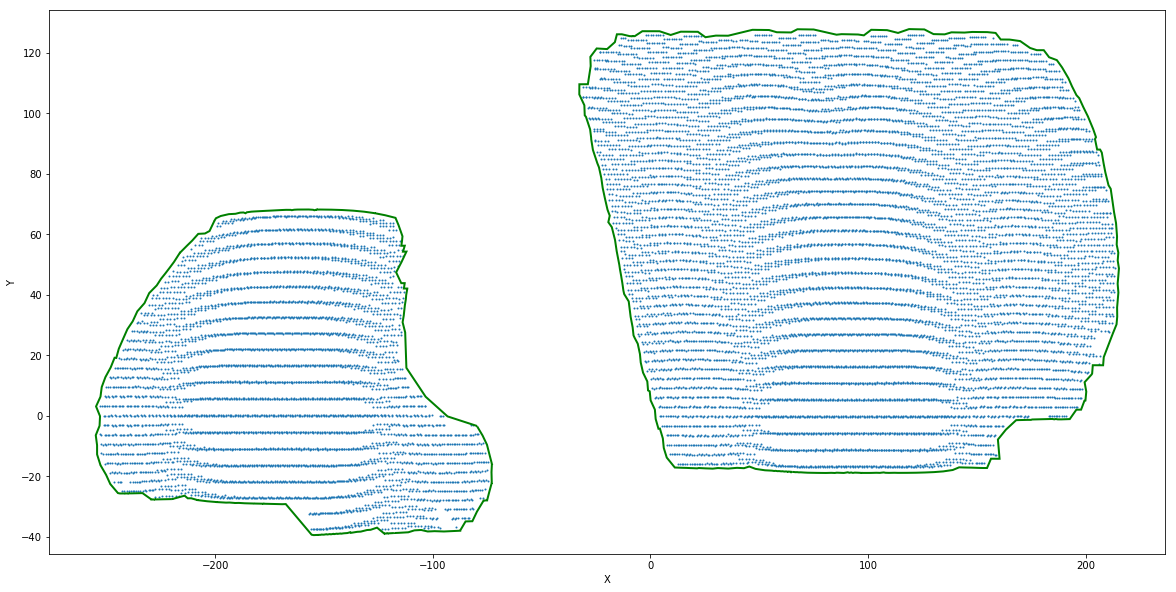

In [22]:
tiles = astropy.table.Table.read('desi-tiles.fits', hdu=1)
sel = (tiles['IN_DESI'] > 0) & (tiles['PASS'] < 8)
ra = tiles['RA'][sel]
dec = tiles['DEC'][sel]

rot = 60
for i in range(0,len(ra)):
    if ra[i] > (360-rot):
        ra[i] = ra[i] + rot - 360
    else:
        ra[i] = ra[i] + rot

x,y = eckertiv(ra,dec)
fig,ax = plot.subplots()
ax.scatter(x, y, s = 1)

mid = []
right = []
left = []

for i in range(0,len(x)):
    if x[i] < -50:
        left.append((x[i], y[i]))
    else:
        right.append((x[i], y[i]))

        
hullleft = jarvis(left)
hullright = jarvis(right)

for i in range(0,3):
    hullleft = improve(hullleft, left)
    hullright = improve(hullright, right)
    
hullleft2 = expand_hull(hullleft)
hullright2 = expand_hull(hullright)

patch1 = Polygon(hullleft, closed = True, fill = False, edgecolor='red',lw=2)
patch2 = Polygon(hullright, closed = True, fill = False, edgecolor='red',lw=2)
patch3 = Polygon(hullleft2, closed = True, fill = False, edgecolor='green',lw=2)
patch4 = Polygon(hullright2, closed = True, fill = False, edgecolor='green',lw=2)

#ax.add_patch(patch1)
#ax.add_patch(patch2)
ax.add_patch(patch3)
ax.add_patch(patch4)

plot.xlabel("X")
plot.ylabel("Y")

fig.set_size_inches(20,10)

plot.show()

In [23]:
f = open('hull.txt', 'w')
f.write(str(hullleft2))
f.write('\n')
f.write(str(hullright2))
f.close()